# Import Section:

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#Tensorflow Neural Network Imports
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Imports for Plots
import os
import numpy as np
import matplotlib.pyplot as plt

#Imports for getting images from directories and Github
import pathlib
import requests, zipfile, io

#Imports for displaying and processing Image files
import IPython.display as display
from PIL import Image

TensorFlow 2.x selected.


# Load GitHub Dataset

In [0]:
####Only One r statement should be uncommented at a time otherwise the second statement will override the first####
#Gets image dataset with grayscale testing images
r = requests.get('https://github.com/brianjhawkins/BearClassificationImages/blob/master/BearClassificationImagesGrayTest.zip?raw=true')

#Gets image dataset with color testing images
#r = requests.get('https://github.com/brianjhawkins/BearClassificationImages/blob/master/BearClassificationImages.zip?raw=true')

z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

#Set Paths to Image directories

In [0]:
#Training image paths
training_images_path = pathlib.Path("/content/BearClassificationImages/TrainingImages/")
training_bears_path = pathlib.Path("/content/BearClassificationImages/TrainingImages/Bear/").glob("*")
training_not_bears_path = pathlib.Path("/content/BearClassificationImages/TrainingImages/NotBear/").glob("*")
training_bears = list(training_bears_path)
training_not_bears = list(training_not_bears_path)

#Testing image paths
testing_images_path = pathlib.Path("/content/BearClassificationImages/TestingImages/")
testing_bears_path = pathlib.Path("/content/BearClassificationImages/TestingImages/Bear/").glob("*")
testing_not_bears_path = pathlib.Path("/content/BearClassificationImages/TestingImages/NotBear/").glob("*")
testing_bears = list(testing_bears_path)
testing_not_bears = list(testing_not_bears_path)

#Counts of the different types of images
numBearsTrain = len(training_bears)
numNotBearsTrain = len(training_not_bears)

numBearsTest = len(testing_bears)
numNotBearsTest = len(testing_not_bears)

training_image_count = numBearsTrain + numNotBearsTrain
testing_image_count = numBearsTest + numNotBearsTest

print('Total training bear images: ', numBearsTrain)
print('Total training not bear images: ', numNotBearsTrain)
print('Total testing bear images: ', numBearsTest)
print('Total testing not bear images: ', numNotBearsTest)
print('--')
print('Total training images: ', training_image_count)
print('Total testing images: ', testing_image_count)



Total training bear images:  220
Total training not bear images:  187
Total testing bear images:  40
Total testing not bear images:  40
--
Total training images:  407
Total testing images:  80


#Class Names

In [0]:
#Array that keeps track of the various types of classes (in this case only 2)
#If more classes are added the neural network model needs to change to be not binary
CLASS_NAMES = np.array([item.name for item in training_images_path.glob("*") if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['NotBear', 'Bear'], dtype='<U7')

#Image Data Generators

In [0]:
#Training image generator that will format images properly for the neural network
# The 1./255 is to convert from uint8 to float32 in range [0,1].
# Randomly rotates input images up to 45 degrees
# Randomly shifts the width and height of input images by up to 15%
# Randomly flips input images based on horizontal or vertical axes
# Randomly zooms in input images by up to 50%
training_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                           rotation_range = 45,
                                                                           width_shift_range = .15,
                                                                           height_shift_range = .15,
                                                                           horizontal_flip = True,
                                                                           vertical_flip = True,
                                                                           zoom_range = 0.5)

#Testing image generator that will format images properly for the neural network
testing_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

#Neural Network input variables
BATCH_SIZE = 32
EPOCHS = 15
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(training_image_count/BATCH_SIZE)

#Defines where and how the input images flow into the training generator
train_data_gen = training_image_generator.flow_from_directory(directory=str(training_images_path),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode = 'binary')

#Defines where and how the input images flow into the testing generator
test_data_gen = testing_image_generator.flow_from_directory(directory=str(testing_images_path),
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode = 'binary')

Found 407 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


#Show Batches

In [0]:
#Simple function that shows some images from a generated batch
def show_batch(image_batch):
  plt.figure(figsize=(20,20))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

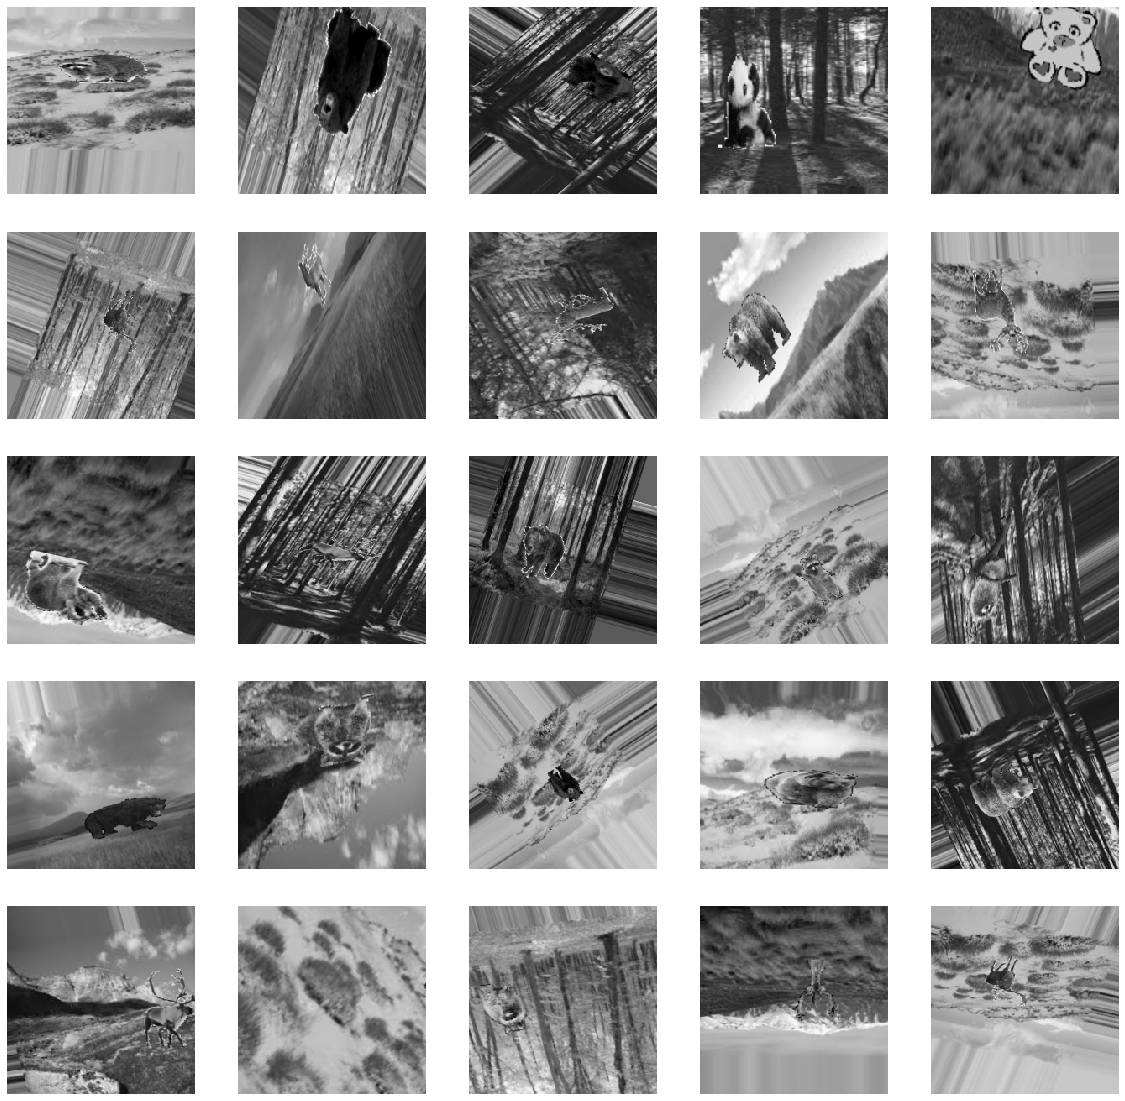

In [0]:
#Shows a generated training image batch
training_image_batch, _ = next(train_data_gen)
show_batch(training_image_batch)

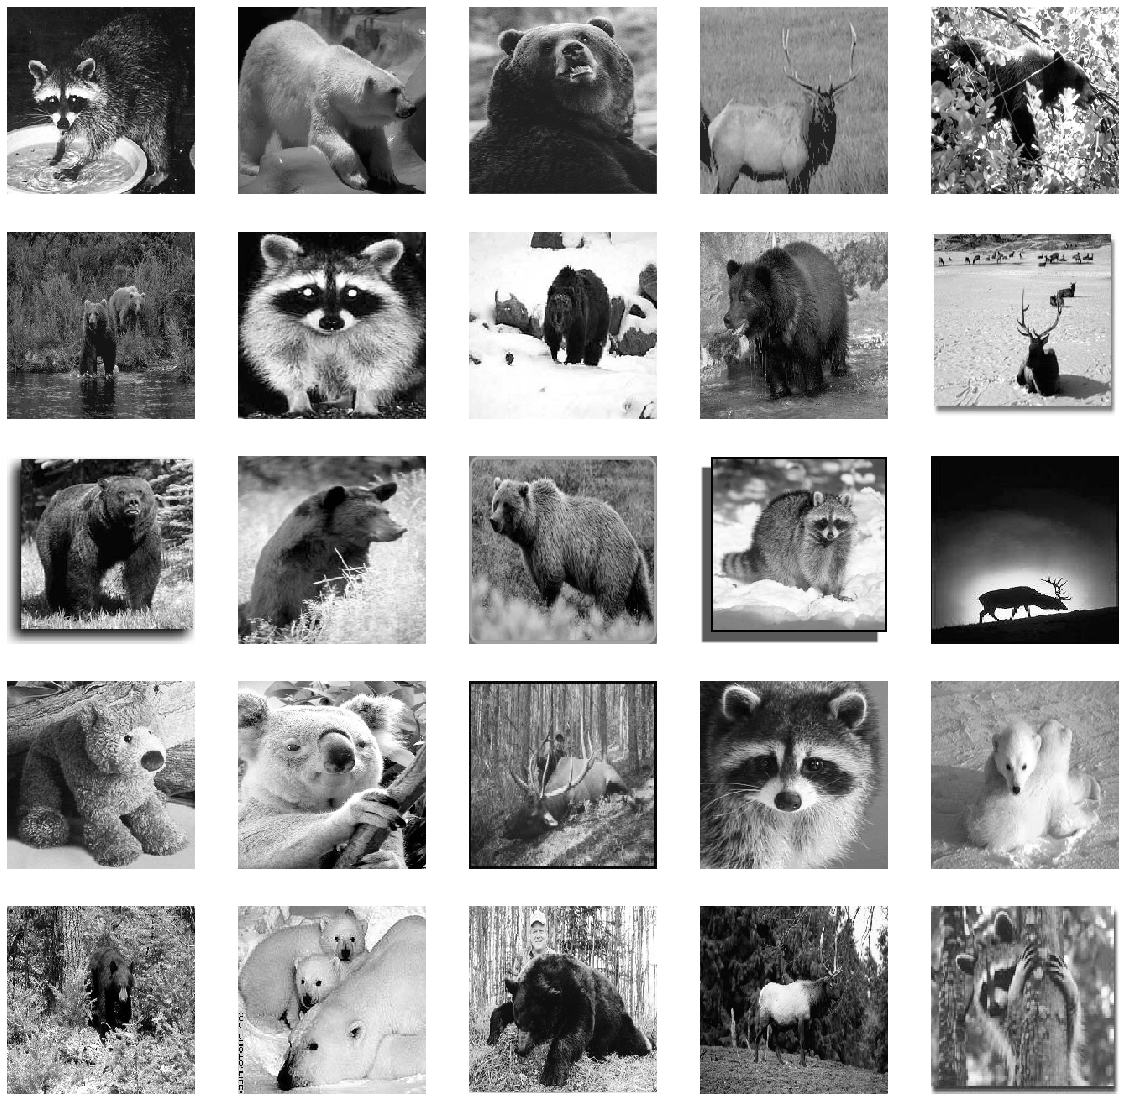

In [0]:
#Shows a generated testing image batch
testing_image_batch, _ = next(test_data_gen)
show_batch(testing_image_batch)

# Build Convolutional Neural Network Model:
  A summary of the model is shown below.

In [0]:
#A simple 3-layer convolutional neural network with some dropout to aid training
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

# Compile and Train Neural Network Model:

In [0]:
#Compiles the model, defines the optimizer and loss, and lists any extra metrics we wish to measure (accuracy)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Stores the history of the model throughout training and validation/testing
history = model.fit_generator(train_data_gen,
                              steps_per_epoch = training_image_count,
                              epochs = EPOCHS,
                              validation_data = test_data_gen,
                              validation_steps = testing_image_count)

Epoch 1/15
407/407 [==============================] - 172s 422ms/step - loss: 0.6553 - accuracy: 0.6176 - val_loss: 1.3455 - val_accuracy: 0.6507
Epoch 2/15
407/407 [==============================] - 167s 410ms/step - loss: 0.5661 - accuracy: 0.6935 - val_loss: 1.4194 - val_accuracy: 0.6381
Epoch 3/15
407/407 [==============================] - 167s 410ms/step - loss: 0.5476 - accuracy: 0.7062 - val_loss: 1.4109 - val_accuracy: 0.6507
Epoch 4/15
407/407 [==============================] - 170s 417ms/step - loss: 0.5321 - accuracy: 0.7268 - val_loss: 1.1313 - val_accuracy: 0.6105
Epoch 5/15
407/407 [==============================] - 165s 406ms/step - loss: 0.5039 - accuracy: 0.7493 - val_loss: 1.9715 - val_accuracy: 0.5891
Epoch 6/15
407/407 [==============================] - 165s 405ms/step - loss: 0.4671 - accuracy: 0.7654 - val_loss: 1.4898 - val_accuracy: 0.6390
Epoch 7/15
407/407 [==============================] - 173s 425ms/step - loss: 0.4329 - accuracy: 0.7930 - val_loss: 1.0987 -

# Evaluate Neural Network Model:

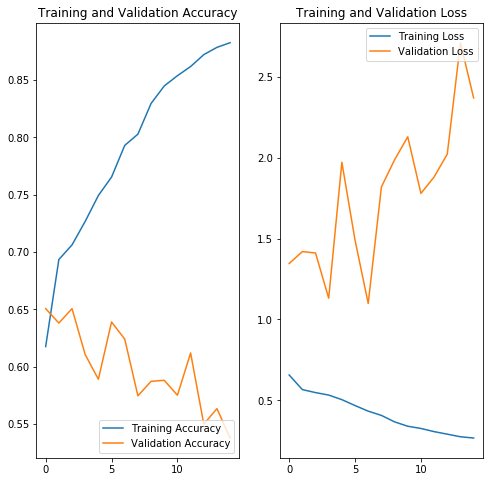

In [0]:
#Takes the history from the model and then plots it into two graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

#This graph compares training and validation accuracy over the epochs
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#This graph compares training and validation loss over the epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()